In [1]:
from pearce.emulator.emu import OriginalRecipe, ExtraCrispy
from pearce.emulator.trainingData import parameter, PARAMS

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from itertools import cycle
colors = cycle(sns.color_palette())

In [3]:
training_dir = '/u/ki/swmclau2/des/PearceLHC/'
fiducial_params = {'logM0': 12.20, 'logM1': 13.7, 'alpha': 1.02,
                      'logMmin': 12.1, 'f_c': 0.19, 'sigma_logM': 0.46}
rbins = np.array([  0.06309573,   0.12437607,   0.24517359,   0.34422476, 0.48329302, 0.67854546,\
           0.9526807 , 1.33756775,1.8779508 ,   2.6366509 ,   3.70186906,   5.19743987, 7.29722764, \
           10.24533859,  14.38449888,  20.1958975 , 28.35512583,  39.81071706] )
rpoints = (rbins[1:]+rbins[:-1])/2

In [4]:
y_param = 'logMmin'
emulation_point = [('f_c', 0.233), ('logM0', 12.0), ('sigma_logM', 0.533), 
                   ('alpha', 1.083),('logM1', 13.5), ('logMmin', 12.233)]
em_params = dict(emulation_point)
del em_params[y_param]

In [5]:
y_param_idx = -1
for idx, p in enumerate(PARAMS):
    if p.name==y_param:
        y_param_idx = idx
        break
        
y_vals = np.linspace(PARAMS[y_param_idx].low, PARAMS[y_param_idx].high, 4)
em_params[y_param] = y_vals

In [6]:
or_params = PARAMS[:]
or_params.append(parameter('r', 0, 1)) #95% sure bounds aren't used for r
emu1 = OriginalRecipe(training_dir,or_params)

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/pearce/emulator/emu.py:482: UserWarning: WARNING: NaN detected. Skipping point in /u/ki/swmclau2/des/PearceLHC/cov_HOD133.npy
  warnings.warn('WARNING: NaN detected. Skipping point in %s' % cov_file)


In [7]:
x = np.array(range(8432))

In [8]:
%%timeit
X = np.outer(x,x)

1 loop, best of 3: 11.1 s per loop


In [9]:
rpoints = np.logspace(np.log10(rbins[0]), np.log10(rbins[-1]), 200)
log_xi_pred, log_xi_cov = emu1.emulate_wrt_r(em_params, rpoints)
log_xi_err = np.sqrt(np.diag(log_xi_cov))
log_xi_pred = log_xi_pred.reshape((-1, len(rpoints)))
log_xi_err = log_xi_err.reshape((-1, len(rpoints)))

In [10]:
truth_dir = '/u/ki/swmclau2/des/PearceData/'
plot_r, plot_xi, plot_xi_err = emu1.get_plot_data(em_params,truth_dir)

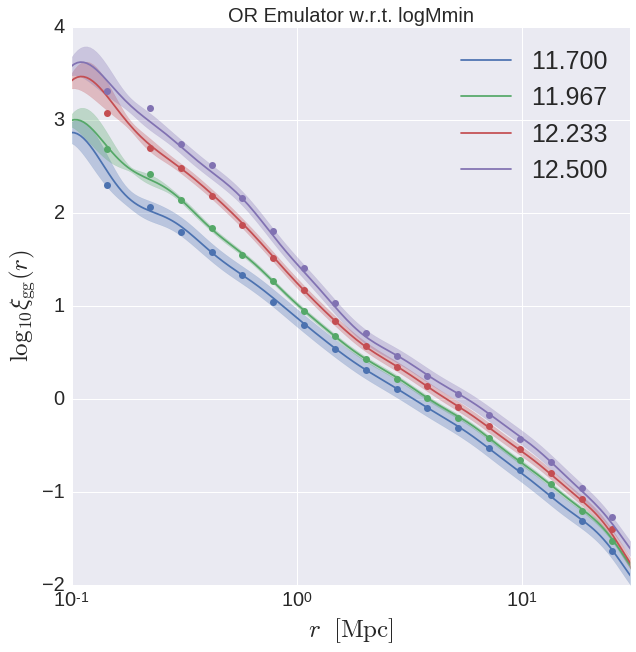

In [11]:
fig = plt.figure(figsize = (10, 10))
for label, lxp, lxe,pr, px, err,c in zip(y_vals, log_xi_pred, log_xi_err ,plot_r, plot_xi,plot_xi_err,colors):

    plt.plot(rpoints, lxp,label = '%.3f'%label, color = c )

    plt.fill_between(rpoints,lxp+lxe,
                     lxp-lxe, color = c, alpha = 0.3)

    plt.errorbar(10**pr, px,err, color =c,fmt = 'o')

plt.xlim(xmin = 0.1, xmax = 30)    
plt.ylim(ymin = -2, ymax = 4)
plt.title("OR Emulator w.r.t. %s"%y_param, fontsize =20)
#plt.loglog()
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$\log_{10}{\xi_{\rm gg}(r) }$', fontsize=25)
plt.legend(loc='best', fontsize=25)

In [12]:
emu2 = ExtraCrispy(training_dir)#no r in params

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/pearce/emulator/emu.py:672: UserWarning: WARNING: NaN detected. Skipping point in /u/ki/swmclau2/des/PearceLHC/cov_HOD133.npy
  warnings.warn('WARNING: NaN detected. Skipping point in %s' % cov_file)


In [13]:
rpoints = np.logspace(np.log10(emu2.rpoints[1]), np.log10(emu2.rpoints[-2]), 200)

In [14]:
log_xi_pred, log_xi_cov = emu2.emulate_wrt_r(em_params,rpoints)
log_xi_err = np.sqrt(np.diag(log_xi_cov))
#print log_xi_pred
log_xi_pred = log_xi_pred.reshape((-1, len(rpoints)))
log_xi_err = log_xi_err.reshape((-1, len(rpoints)))

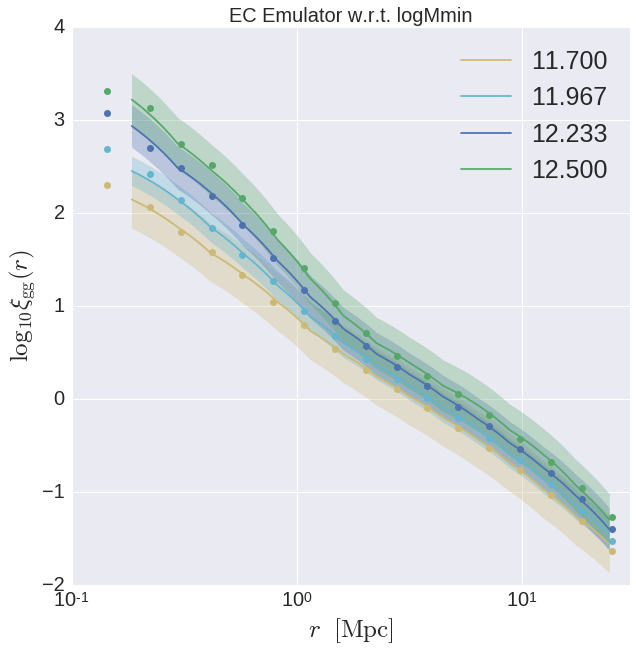

In [15]:
fig = plt.figure(figsize = (10, 10))
for label, lxp, lxe,pr, px, err,c in zip(y_vals, log_xi_pred, log_xi_err ,plot_r, plot_xi,plot_xi_err,colors):

    plt.plot(rpoints, lxp,label = '%.3f'%label, color = c )

    plt.fill_between(rpoints,lxp+lxe,
                     lxp-lxe, color = c, alpha = 0.3)

    plt.errorbar(10**pr, px,err, color =c,fmt = 'o')

plt.xlim(xmin = 0.1, xmax = 30)    
plt.ylim(ymin = -2, ymax = 4)
plt.title("EC Emulator w.r.t. %s"%y_param, fontsize =20)
#plt.loglog()
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$\log_{10}{\xi_{\rm gg}(r) }$', fontsize=25)
plt.legend(loc='best', fontsize=25)

In [16]:
from os import path

In [17]:
save_dir = '/u/ki/swmclau2/des/EmulatorMCMC/'
true_rpoints = np.log10(np.loadtxt(path.join(save_dir, 'rpoints.npy')))
y = np.loadtxt(path.join(save_dir, 'xi.npy'))
cov = np.loadtxt(path.join(save_dir, 'cov.npy'))
true_cov = cov/(np.outer(y,y)*np.log(10)**2)
#T = np.diag(np.diag(T))
true_y = np.log10(y)

In [18]:
import emcee as mc
from itertools import izip
nwalkers = 100
n_cores = 2
nsteps = 10
nburn = 1

In [19]:
from pearce.emulator.emu import lnprob as lnprob2

In [20]:
emu2.run_mcmc(true_y, true_cov, true_rpoints)

KeyboardInterrupt: 